## **Importing Libraries,Datasets**

In [16]:
#Library for vizualizing the decision trees
!pip install dtreeviz

In [17]:
#data manipulation libraries
import pandas as pd
import numpy as np

#data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['image.cmap'] = 'Set1'

#classes and functions for data preprocessing
from  sklearn.preprocessing                       import  LabelEncoder,OneHotEncoder,MinMaxScaler,StandardScaler
from  sklearn.model_selection                     import  train_test_split,StratifiedKFold

#classes for ml algorithms
from  sklearn.linear_model                        import  LinearRegression,LogisticRegression
from  sklearn.tree                                import  DecisionTreeClassifier
from  sklearn.ensemble                            import  RandomForestClassifier
from  sklearn.naive_bayes                          import  GaussianNB
#functions for model evaluation
from  sklearn.metrics                             import  *

#functions for vizualising the model
from  dtreeviz.trees                              import dtreeviz
from sklearn.metrics                              import plot_confusion_matrix
from sklearn.model_selection                      import GridSearchCV
#for multple output in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [18]:
#loading dataset
train = pd.read_csv('dataset/dream_house_loan_train.csv')
test = pd.read_csv('dataset/dream_house_loan_test.csv')

## **Helper Functions**

In [19]:
def plot_stacked_bar(x,cols,data,normalized=True):
  '''
  This function will plot the stacked bar chart of different categorical variables
  '''
  m=int(np.ceil(len(cols)/2))
  n= 1 if len(cols) == 1 else 2
  fig,axes = plt.subplots(m,n,figsize=(n*5,m*4))
  axes = axes.ravel() if n!=1 else axes
  plt.tight_layout()

  for i,c in enumerate(train[cols]):
    count_df = train.groupby([c,x]).size().unstack()
    if normalized:
      
      percent_df = count_df.T.div(count_df.T.sum()).T
      _=percent_df.plot(kind='bar',stacked=True,ax=axes[i] if n!=1 else axes,rot=0)
    else:
      _=count_df.plot(kind='bar',stacked=True,ax=axes[i] if n!=1 else axes,rot=0)

In [20]:
def plot_pie_chart(cols,data):

  m=int(np.ceil(len(cols)/2))
  n= 1 if len(cols) == 1 else 2
  fig,axes = plt.subplots(m,n,figsize=(n*5,m*4))
  axes = axes.ravel() if n!=1 else axes
  plt.tight_layout()

  for i,c in enumerate(train[cols]):
    _ = train[c].value_counts()[::-1].plot(kind='pie',autopct='%.0f',ax =axes[i],title=c)
    _ = axes[i].set_ylabel('')

In [21]:
def impute_missing_loan_amount(df,features):
  #A function to impute missing values present in the loan amount column
  #A simple linear regression model is used to predict the missing values
  data =df.copy()
  cat_cols = ['Gender', 'Married','Dependents','Education','Self_Employed','Credit_History','Property_Area']
  for col in list(filter(lambda i :i in features,cat_cols)) :
    le = LabelEncoder()
    data[col] = le.fit_transform(data.loc[:,col])
  m_train = data[~data.LoanAmount.isnull()]
  m_test = data[data.LoanAmount.isnull()]
  regressor = LinearRegression()
  regressor.fit(m_train[features],m_train['LoanAmount'])
  y_pred = pd.Series(data=regressor.predict(m_test[features]),index=m_test.index)
  return y_pred

In [22]:
#function for calculating emi feature
def emi_calculator(x):
  p=x[0]
  n=x[1]
  r = 0.09 / 12.0
  a=(1+r)**n
  emi = (p*r) * (a/(a-1))
  return np.round(emi*1000,2)

In [23]:
def get_optimal_accuracy_thresh(target,oofs):

  '''
  A function that returns optimal threshold for a given predicted values
  '''
  thresholds = np.arange(0,100)/100
  thresh_scores=[]
  for thresh in thresholds:
    oofs_pred = (oofs > thresh)*1
    thresh_score = accuracy_score(target,oofs_pred)
    thresh_scores.append(thresh_score)

  all_thresh_scores = pd.Series(index=thresholds,data=thresh_scores)
  all_thresh_scores.plot(figsize=(10,6),fontsize=14)

  plt.xlabel('Threshold',fontsize=14)
  plt.ylabel('Accuracy Score',fontsize=14)
  
  return all_thresh_scores.sort_values(ascending = False).index.values[0]

## **Data Analysis**

In [24]:
ID,TARGET_COL = 'Loan_ID','Loan_Status'
features = [col for col in train.columns if col not in [ID,TARGET_COL]]
features

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'Property_Area']

In [25]:
num_cols = [
            'ApplicantIncome',
            'CoapplicantIncome',
            'LoanAmount',
            'Loan_Amount_Term'
]
cat_cols = [col for col in features if col not in num_cols]

### Brief overview of datasets

In [26]:
print(f"\nTrain set has {train.shape[0]} rows and {train.shape[1]} columns")
print(f"\nTest set has {test.shape[0]} rows and {test.shape[1]} columns")
print(f"\nThe dataset contains initially {len(features)} features")


Train set has 614 rows and 13 columns

Test set has 367 rows and 12 columns

The dataset contains initially 11 features


In [27]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


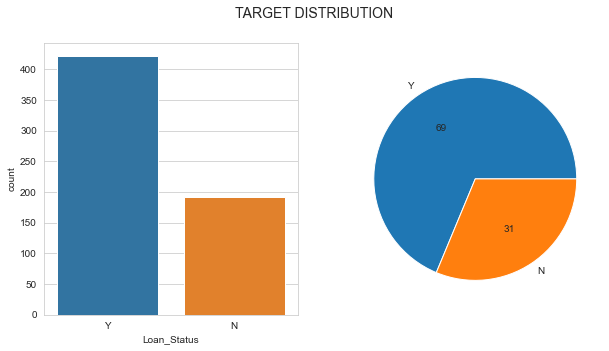

In [28]:
fig = plt.figure(figsize=(10,5))
_ =plt.suptitle('TARGET DISTRIBUTION',fontsize=14)
countplt = plt.subplot(1,2,1)
_ = sns.countplot(x=TARGET_COL,data=train)

pie=plt.subplot(1,2,2)
_ = train[TARGET_COL].value_counts().plot(kind='pie',autopct='%.0f')
_ =plt.ylabel('')



In [29]:
null_values_per_variable = ((train[features].isnull().sum()/train.shape[0]) * 100).round(3)

In [30]:
train[features].nunique()

Gender                 2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           203
Loan_Amount_Term      10
Credit_History         2
Property_Area          3
dtype: int64

### Categorical Features

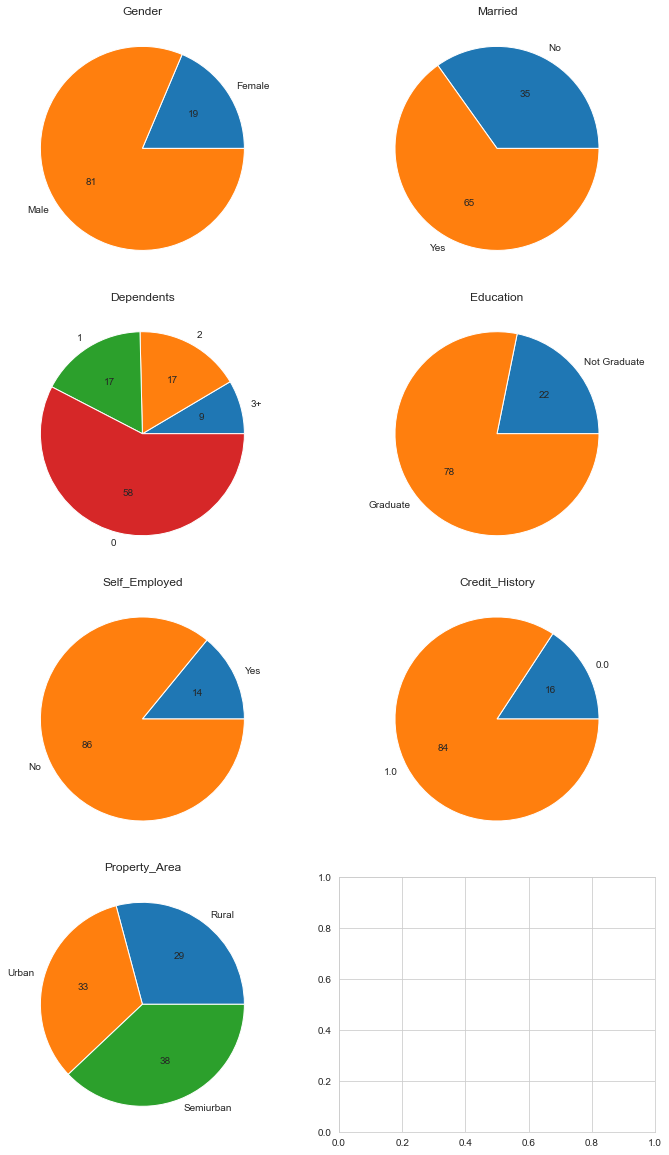

In [31]:
plot_pie_chart(cat_cols,train)

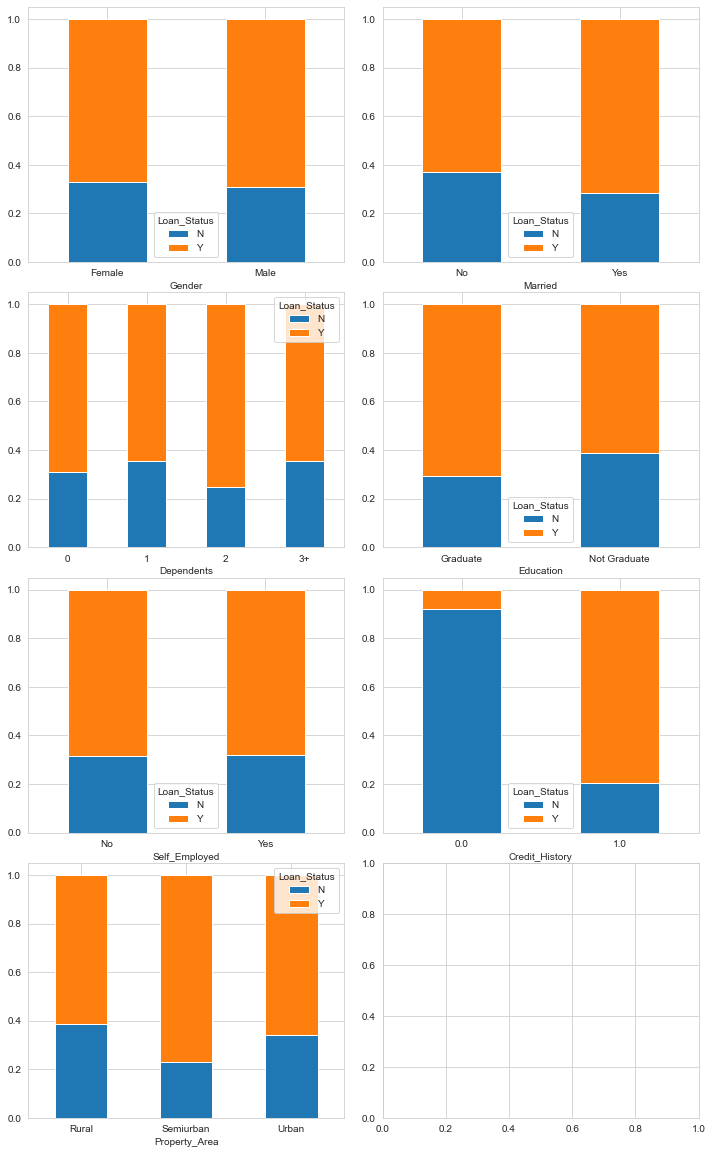

In [32]:
plot_stacked_bar(x='Loan_Status',cols=cat_cols,data=train)

Inferences:

1. Approximately 10% more of Customers who have the property in semi-urban area got the loan approved comparing other customers

2. Only few customers got the loan when they have a bad credit history

### Numerical Features

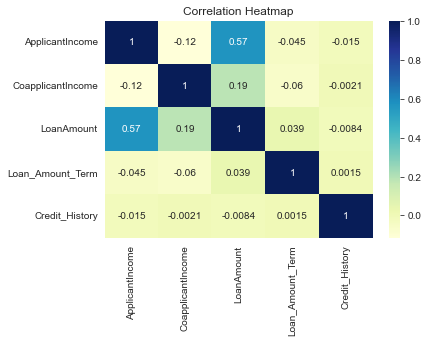

In [33]:
_=sns.heatmap(train.corr(),cmap='YlGnBu',annot=True).set_title('Correlation Heatmap')

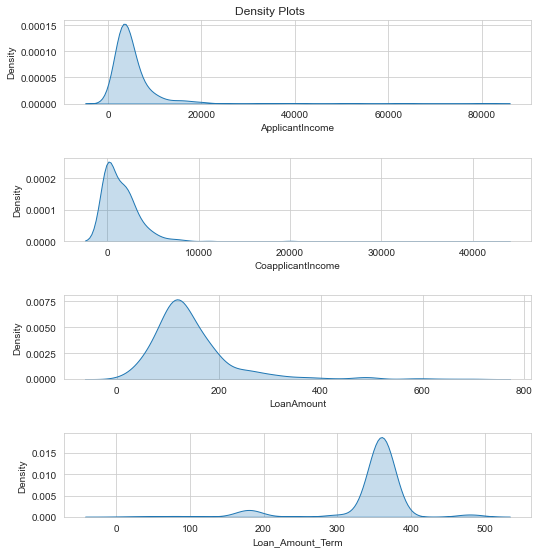

In [34]:
fig,axes= plt.subplots(4,1,figsize=(8,8))

for i,c in enumerate(num_cols):
  _ = sns.kdeplot(x=c,data=train,ax=axes[i],fill=True)
  _ = fig.suptitle('Density Plots')
plt.tight_layout(pad=2.5)

### Credit History

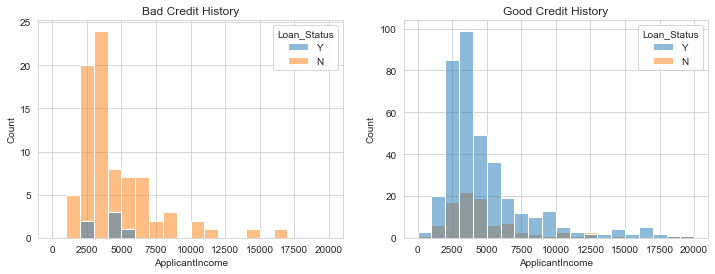

In [35]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
plt1=sns.histplot(x='ApplicantIncome',data=train[train.Credit_History==0],binrange=(0,20000),bins=20,hue=TARGET_COL,hue_order=['Y','N'],ax=ax[0])
_=plt1.set(title="Bad Credit History")

plt2=sns.histplot(x='ApplicantIncome',data=train[train.Credit_History==1],binrange=(0,20000),bins=20,hue=TARGET_COL,ax=ax[1])
plt2=plt2.set(title="Good Credit History")

In [36]:
train.Credit_History.value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

In [37]:
train.groupby([TARGET_COL,'Credit_History']).size().unstack()

Credit_History,0.0,1.0
Loan_Status,,
N,82,97
Y,7,378


In [38]:
cols=['Gender','Married','Education','Self_Employed']

In [39]:
for col in cols:
  print(train.groupby([col,'Credit_History']).size().unstack())
  print("------------------------------------------------------\n")

Credit_History  0.0  1.0
Gender                  
Female           17   84
Male             69  382
------------------------------------------------------

Credit_History  0.0  1.0
Married                 
No               32  167
Yes              57  305
------------------------------------------------------

Credit_History  0.0  1.0
Education               
Graduate         63  380
Not Graduate     26   95
------------------------------------------------------

Credit_History  0.0  1.0
Self_Employed           
No               76  387
Yes              12   63
------------------------------------------------------



## **Data Preparation**

In [40]:
df = pd.concat([train,test],axis=0).reset_index(drop=True)
print(f"DataFrame has {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

DataFrame has 981 rows and 13 columns


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### Missing Values Imputation

In [41]:
#Adding a TotalIncome column
df['TotalIncome'] = df['ApplicantIncome']+df['CoapplicantIncome']
num_cols.append('TotalIncome')

In [42]:
#imputing missing values in categorical features
df['Gender'] = df['Gender'].fillna(df.Gender.mode()[0])
df.Married = df.Married.fillna(df.Married.mode()[0])
df.Dependents = df.Dependents.fillna(df.Dependents.mode()[0])
df.Self_Employed = df.Self_Employed.fillna(df.Self_Employed.mode()[0])
df.Loan_Amount_Term = df.Loan_Amount_Term.fillna(df.Loan_Amount_Term.mode()[0])
df.Credit_History.fillna('unknown',inplace=True)
#imputing missing values in numerical features
y_pred = np.round(impute_missing_loan_amount(df,['TotalIncome','Education']),0)
df.loc[y_pred.index,'LoanAmount'] = y_pred

### Predicting missing negative values

In [43]:
data = df.copy()
for col in ['Gender','Dependents']:
  le = LabelEncoder()
  data.loc[:,col] = le.fit_transform(df[col])
data['Married'] = data['Married'].map({'Yes':1,'No':0})
data['Education'] = data['Education'].map({'Graduate':1,'Not Graduate':0})
data['Property_Area'] = data['Property_Area'].map({'Rural':1,'Urban':2,'Semiurban':3})
data['Self_Employed'] = data['Self_Employed'].map({'Yes':1,'No':0})

input_cols = [col for col in data.columns if col not in [TARGET_COL,ID,'Credit_History']]

###Adding New Features

In [44]:
df['AmountPerIncome'] = (df['LoanAmount'] * 1000) / df['TotalIncome']
df['emi'] = df[['LoanAmount','Loan_Amount_Term']].apply(emi_calculator,axis=1)
df['LogTotalIncome'] = np.log10(df['TotalIncome'])
df['LogLoanAmount'] = np.log10(df['LoanAmount'])
features.extend(['AmountPerIncome','emi','LogTotalIncome','LogLoanAmount'])
num_cols.extend(['AmountPerIncome','emi','LogTotalIncome','LogLoanAmount'])

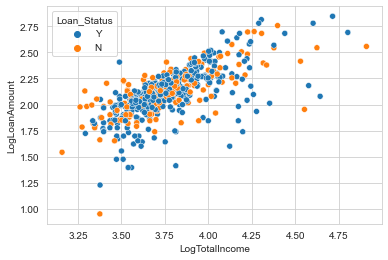

In [45]:
sns.scatterplot(x="LogTotalIncome",y="LogLoanAmount",data=df[:train.shape[0]],hue="Loan_Status")

In [46]:

#spliting into train,test,cross validating sets
train = df.iloc[0:train.shape[0],:]
test = df.iloc[train.shape[0]:,:].reset_index(drop=True)
train,cv= train_test_split(train,test_size=0.25,random_state=42)

train = train.reset_index(drop=True)
cv = cv.reset_index(drop=True)

train['Loan_Status'] = train['Loan_Status'].map({'Y':1,'N':0})
cv['Loan_Status'] = cv['Loan_Status'].map({'Y':1,'N':0})

data = pd.concat([train,cv,test]).reset_index(drop=True)

## **Modeling**

In [47]:
#dataframe to save best accuracy of each classification model
model_accuracy_df=pd.DataFrame(columns=['Model_Name','Training_Accuracy','Validation_Accuracy'])

In [48]:
#data preparation for logistic regression
df = data.copy()
for col in ['Gender','Dependents']:
  le = LabelEncoder()
  df.loc[:,col] = le.fit_transform(df[col])
df['Married'] = df['Married'].map({'Yes':1,'No':0})
df['Education'] = df['Education'].map({'Graduate':1,'Not Graduate':0})
df['Property_Area'] = df['Property_Area'].map({'Rural':1,'Urban':2,'Semiurban':3})
df['Self_Employed'] = df['Self_Employed'].map({'Yes':1,'No':0})
df = pd.get_dummies(df,columns=['Credit_History'])

train = df.iloc[0:train.shape[0],:]
train['Loan_Status'] = train['Loan_Status'].astype(int)
cv=df.iloc[train.shape[0]:train.shape[0]+cv.shape[0],:]
cv['Loan_Status'] = cv['Loan_Status'].astype(int)
test = df.iloc[train.shape[0]+cv.shape[0]:,:]
features = [col for col in train.columns if col not in [ID,TARGET_COL]]
for col in ['ApplicantIncome','CoapplicantIncome','LoanAmount','TotalIncome']:
  features.remove(col)

<ipython-input-48-1ef4b0ed1f2e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Loan_Status'] = train['Loan_Status'].astype(int)
<ipython-input-48-1ef4b0ed1f2e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['Loan_Status'] = cv['Loan_Status'].astype(int)


### LogisticRegression

In [54]:
logit = LogisticRegression(C=1,solver='liblinear',max_iter=400)
_ = logit.fit(train[features],train[TARGET_COL])
train_preds = logit.predict(train[features])
cv_preds = logit.predict(cv[features])
train_preds = (train_preds>0.5)*1
cv_preds = (cv_preds>0.5)*1
train_acc= accuracy_score(train[TARGET_COL],train_preds)
val_acc = accuracy_score(cv[TARGET_COL],cv_preds)
print("Training accuracy :",train_acc)
print("Validation accuracy :",val_acc)
print(confusion_matrix(cv[TARGET_COL],cv_preds))

Training accuracy : 0.8217391304347826
Validation accuracy : 0.7727272727272727
[[21 33]
 [ 2 98]]


In [55]:
model_accuracy_df.loc[len(model_accuracy_df.index)] = ['LogisticRegression', train_acc, val_acc] 

### Decision Tree

In [56]:
params = {'criterion' : ['gini','entropy'],
          'max_depth':[5,6,7,8,9],
          'max_features':[0.6,0.7,0.8,0.9,1],
          'min_samples_leaf':[1,2,4,8,16],
          'random_state':[42]}
base = DecisionTreeClassifier()
search = GridSearchCV(base, params)
_=search.fit(train[features],train[TARGET_COL])
print(search.best_params_)

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 0.6, 'min_samples_leaf': 16, 'random_state': 42}


In [57]:
dtree = DecisionTreeClassifier(min_samples_split=10,max_depth=6)
_=dtree.fit(train[features],train[TARGET_COL])
tree_train_preds = dtree.predict(train[features])
tree_val_preds = dtree.predict(cv[features])
tree_train_acc = accuracy_score(train[TARGET_COL],tree_train_preds)
tree_val_acc = accuracy_score(cv[TARGET_COL],tree_val_preds)
print("Training accuracy :",accuracy_score(train[TARGET_COL],tree_train_preds))
print("Validation accuracy :",accuracy_score(cv[TARGET_COL],tree_val_preds))
print(confusion_matrix(cv[TARGET_COL],tree_val_preds))

Training accuracy : 0.8478260869565217
Validation accuracy : 0.7857142857142857
[[25 29]
 [ 4 96]]


In [58]:
viz = dtreeviz(dtree,train[features],train[TARGET_COL],target_name=TARGET_COL,feature_names=features,title='Loan prediction',class_names=['No','Yes'],scale=1.2)

In [62]:
#this code may be shown as error in your computer.It's because you didn't installed required libraries into your system
#try it on google colab to see the visualization
viz

ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

In [60]:
feature_importances = pd.DataFrame({'feature':features,'importance':dtree.feature_importances_}).sort_values('importance',ascending=False)
feature_importances.head()

,feature,importance
11,Credit_History_0.0,0.677333
9,LogTotalIncome,0.136094
7,AmountPerIncome,0.107693
6,Property_Area,0.025509
0,Gender,0.019335


### XGBoost

In [63]:
from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
xgb = XGBClassifier(random_state=42, n_jobs=-1,
                    n_estimators=100,colsample_bytree=0.7,min_child_weight=0.1,reg_alpha=5)
_=xgb.fit(train[features],train[TARGET_COL])
xgb_train_preds = xgb.predict(train[features])
xgb_val_preds = xgb.predict(cv[features])
print("Training Accuracy : ",accuracy_score(train[TARGET_COL],xgb_train_preds))
print("Valiidation Accuracy : ",accuracy_score(cv[TARGET_COL],xgb_val_preds))